In [2]:
import os
os.chdir('../')

## Imports

In [3]:
import pandas as pd
import datetime as dt

from risk_suite.economics import EconomicsCalculator

## Data Collect

#### Score Imobiliária

In [4]:
all_preds = []

for month in range(1, 7):
    all_preds.append(f"notebooks/outputs/df_preds_20220{month}.csv")

df_preds = (
    pd.concat([pd.read_csv(f) for f in all_preds ])
    [["dt_calendar", "id_imobiliaria", "segments"]]
    .rename(columns={"dt_calendar": "dt_ativacao"})
)

df_preds["dt_ativacao"] = pd.to_datetime(df_preds["dt_ativacao"]).dt.strftime("%Y-%m")

In [5]:
info_contracts = (
    pd.read_csv("data/info_contracts.csv")[["dt_ativacao", "id_imobiliaria", "id_contrato"]]
    .rename(columns={"id_contrato": "contract_id"})
)

info_contracts["dt_ativacao"] = pd.to_datetime(info_contracts["dt_ativacao"]).dt.strftime("%Y-%m")

In [6]:
df_preds.groupby("segments")["id_imobiliaria"].size()

segments
A    345
B    461
C    448
D    466
E    566
Name: id_imobiliaria, dtype: int64

In [7]:
df = info_contracts.merge(df_preds, on=["dt_ativacao", "id_imobiliaria"])
df

,dt_ativacao,id_imobiliaria,contract_id,segments
0,2022-01,38,472480,B
1,2022-01,38,473211,B
2,2022-01,38,477113,B
3,2022-01,38,479053,B
4,2022-01,38,479355,B
...,...,...,...,...
35243,2022-05,28927,617454,A
35244,2022-06,28927,641306,A
35245,2022-06,28927,650933,A
35246,2022-06,28927,657806,A


#### Risco atual

In [ ]:
calendar = pd.DataFrame(pd.date_range("2022-01", "2022-07", freq="M").strftime("%Y-%m"), columns=["dt_ativacao"])

In [ ]:
old_score = pd.read_csv("data/old_risco_imob.csv")[["id_imobiliaria", "risco_imobiliaria"]].query("risco_imobiliaria != 0")

old_score["segments"] = (
    old_score["risco_imobiliaria"]
    .transform(
        lambda x: "A" if x == 2      else
                  "B" if x in (3, 4) else 
                  "C" if x == 5      else 
                  "D" if x == 6      else 
                  "E" if x == 7      else 
                  None
    )
)

old_score = old_score.merge(calendar, how="cross")
old_score.head()

In [112]:
old_score.groupby("segments")["id_imobiliaria"].size()

segments
A     288
B      42
C    1134
D    1752
E    2154
Name: id_imobiliaria, dtype: int64

In [94]:
old_risk = info_contracts.merge(old_score[["dt_ativacao", "id_imobiliaria", "segments"]], on=["dt_ativacao", "id_imobiliaria"])
old_risk.head()

,dt_ativacao,id_imobiliaria,contract_id,segments
0,2022-01,30,480160,D
1,2022-02,30,501215,D
2,2022-02,30,503926,D
3,2022-02,30,511972,D
4,2022-02,30,534486,D


#### Calculadora

In [8]:
contracts = pd.read_parquet('../risk_suite/data/contracts.parquet')
defaults = pd.read_parquet('../risk_suite/data/defaults.parquet')
recoveries = pd.read_parquet('../risk_suite/data/recoveries.parquet')
revenues = pd.read_parquet('../risk_suite/data/revenues.parquet')

base_features = [
    'contract_id',
    'activation_date',
    'churn_date',
    'activation_month',
    'activation_quarter',
    'score_serasa',
    'rating',
    'rental_value',
]

contracts = contracts[base_features]
contracts = contracts.dropna(subset=['activation_date', 'rating'])
contracts = contracts.loc[lambda x: x['activation_quarter'] >= pd.Period('2020Q1')]
contracts = contracts.replace(['E1', 'E2', 'E3'], 'E')

## Auxiliary Functions

In [9]:
def report_economics2(aggkeys, revenues_pivot, defaults_pivot, recoveries_pivot):

    economics_df = pd.DataFrame(
        {
            'n_contracts': revenues_pivot.groupby(aggkeys).size(),
            'revenue_value': (revenues_pivot.sum(axis=1)).groupby(aggkeys).mean(),
            'prob_default': (defaults_pivot.sum(axis=1) > 0).groupby(aggkeys).mean(),
            'default_value': (defaults_pivot.sum(axis=1)).groupby(aggkeys).mean(),
            'recovery_value': (recoveries_pivot.sum(axis=1)).groupby(aggkeys).mean()
        }
    )

    economics_df = (
        economics_df
        .assign(recovery_efficiency=lambda x: x['recovery_value'] / x['default_value'])
        .assign(unit_economics=lambda x: x['revenue_value'] - x['default_value'] + x['recovery_value'])
        .assign(aggregate_margin=lambda x: x['unit_economics'] * x['n_contracts'])
    )

    return economics_df.sort_index(ascending=[True, False])

## Economics report

In [10]:
df = contracts.merge(df, on="contract_id")

In [11]:
econ_calculator = EconomicsCalculator(df, defaults, recoveries, revenues, max_history_date='2023-01')

defaults_pivot = econ_calculator._build_defaults_pivot()
recoveries_pivot = econ_calculator._build_recoveries_pivot()
revenues_pivot = econ_calculator._build_revenues_pivot()

report = report_economics2(["segments"], revenues_pivot, defaults_pivot, recoveries_pivot)

/Users/raquel.camara/opt/anaconda3/lib/python3.9/site-packages/risk_suite/economics.py:139: FutureWarning: pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.
  event_data


In [12]:
report

,n_contracts,revenue_value,prob_default,default_value,recovery_value,recovery_efficiency,unit_economics,aggregate_margin
segments,,,,,,,,
A,1271,1335.677663,0.052714,270.501857,98.335980,0.363532,1163.511786,1478823.48
B,3354,1214.062275,0.064103,347.241855,107.349120,0.309148,974.169541,3267364.64
C,5833,1140.376235,0.065832,353.497725,107.667615,0.304578,894.546125,5217887.55
D,5967,1132.072073,0.108765,696.862427,195.004444,0.279832,630.214091,3760487.48
E,18454,1136.454054,0.124688,870.064657,239.138413,0.274851,505.527810,9329010.21


#### Risco Atual

In [95]:
# imobs = (df.id_imobiliaria.unique())
old_risk_2 = contracts.merge(old_risk, on="contract_id")#.query("id_imobiliaria in @imobs")

In [101]:
econ_calculator_old = EconomicsCalculator(old_risk.query("id_imobiliaria in @imobs"), defaults, recoveries, revenues, max_history_date='2023-01')

defaults_pivot_old = econ_calculator_old._build_defaults_pivot()
recoveries_pivot_old = econ_calculator_old._build_recoveries_pivot()
revenues_pivot_old = econ_calculator_old._build_revenues_pivot()

report_old = report_economics2(["segments"], revenues_pivot_old, defaults_pivot_old, recoveries_pivot_old)

/Users/raquel.camara/opt/anaconda3/lib/python3.9/site-packages/risk_suite/economics.py:139: FutureWarning: pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.
  event_data


In [97]:
report_old

,n_contracts,revenue_value,prob_default,default_value,recovery_value,recovery_efficiency,unit_economics,aggregate_margin
segments,,,,,,,,
A,1570,1137.982134,0.026752,164.519268,28.650713,0.174148,1002.113580,1573318.32
B,2757,1218.591792,0.073993,543.509587,156.801110,0.288497,831.883315,2293502.30
C,7562,1170.826014,0.051970,307.080665,107.639807,0.350526,971.385156,7345614.55
D,14046,1196.827674,0.080806,516.389433,159.738427,0.309337,840.176668,11801121.48
E,22243,1124.420053,0.136762,875.796947,236.966910,0.270573,485.590016,10800978.73


In [106]:
old_score.groupby("segments")["id_imobiliaria"].size()

segments
A     288
B      42
C    1134
D    1752
E    2154
Name: id_imobiliaria, dtype: int64

In [105]:
old_score.id_imobiliaria.nunique()

895

### Análises 1

In [16]:
df.groupby(["segments"])["contract_id"].size()

segments
A     1271
B     3354
C     5833
D     5967
E    18454
Name: contract_id, dtype: int64

In [22]:
df_pivot = (df.groupby(["segments", "rating"])["contract_id"].size() / df.groupby(["segments"])["contract_id"].size()).to_frame().reset_index()

In [24]:
pd.pivot_table(df_pivot, values="contract_id", index="segments", columns="rating")

rating,A,B,C,D,E
segments,,,,,
A,0.195909,0.259638,0.346971,0.073958,0.123525
B,0.156231,0.235540,0.339595,0.124329,0.144305
C,0.161666,0.231442,0.334133,0.124293,0.148466
D,0.158539,0.225909,0.341042,0.122507,0.152003
E,0.154221,0.234204,0.339168,0.119866,0.152541


In [19]:
(df.groupby(["segments", "rating"])["contract_id"].size() / df.groupby(["segments"])["contract_id"].size()).to_frame()

contract_id
segments rating             
A        A          0.195909
         B          0.259638
         C          0.346971
         D          0.073958
         E          0.123525
B        A          0.156231
         B          0.235540
         C          0.339595
         D          0.124329
         E          0.144305
C        A          0.161666
         B          0.231442
         C          0.334133
         D          0.124293
         E          0.148466
D        A          0.158539
         B          0.225909
         C          0.341042
         D          0.122507
         E          0.152003
E        A          0.154221
         B          0.234204
         C          0.339168
         D          0.119866
         E          0.152541

### Análises 2

In [133]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [200]:
report_ativacao = report_economics2(["dt_ativacao", "segments"], revenues_pivot, defaults_pivot, recoveries_pivot)
report_old_risk = report_economics2(["dt_ativacao", "segments"], revenues_pivot_old, defaults_pivot_old, recoveries_pivot_old)

report_ativacao = report_ativacao.reset_index()
report_old_risk = report_old_risk.reset_index()

report_ativacao["dt_ativacao"] = pd.to_datetime(report_ativacao["dt_ativacao"])
report_old_risk["dt_ativacao"] = pd.to_datetime(report_old_risk["dt_ativacao"])

#### Score Imobiliária

In [204]:
def get_lineplot(
  data_list,
  specs
):
    month_fmt = mdates.DateFormatter('%b %Y')
    month = mdates.DayLocator(interval=30)
    
    # fig = plt.figure(figsize=(25,13), dpi=80)
    fig = plt.figure(figsize=(25,13), dpi=80)
    ax = fig.add_gridspec(2, 2)
    
    ax_list = [f"ax_{n}" for n in specs.keys()]
    idx = 0
    
    for data in data_list:
        with sns.axes_style('white'):
          ax_list[idx] = fig.add_subplot(ax[specs[idx]["x_grid_loc"], specs[idx]["y_grid_loc"]])

          ax1 = sns.lineplot(data=data,
                            x='dt_ativacao',
                            y=specs[idx]["y_axis"],
                            hue=specs[idx]["hue"],
                            ci=None)

          # setting up style
          sns.despine(top=True)

          # setting up axis and title
          plt.title(specs[idx]["title"], fontsize=16, fontweight='bold')
          plt.xlabel('', fontsize=13, fontweight='bold')
          plt.ylabel('', fontsize=13, fontweight='bold')
          plt.rcParams['xtick.labelsize'] = 10
          plt.rcParams['ytick.labelsize'] = 10

          ax_list[idx].xaxis.set_major_formatter(month_fmt)
          ax_list[idx].xaxis.set_major_locator(month)
          ax_list[idx].set_ylim([0, .2])
          
          plt.xticks(rotation=20)
    
          idx += 1

    return plt.show()

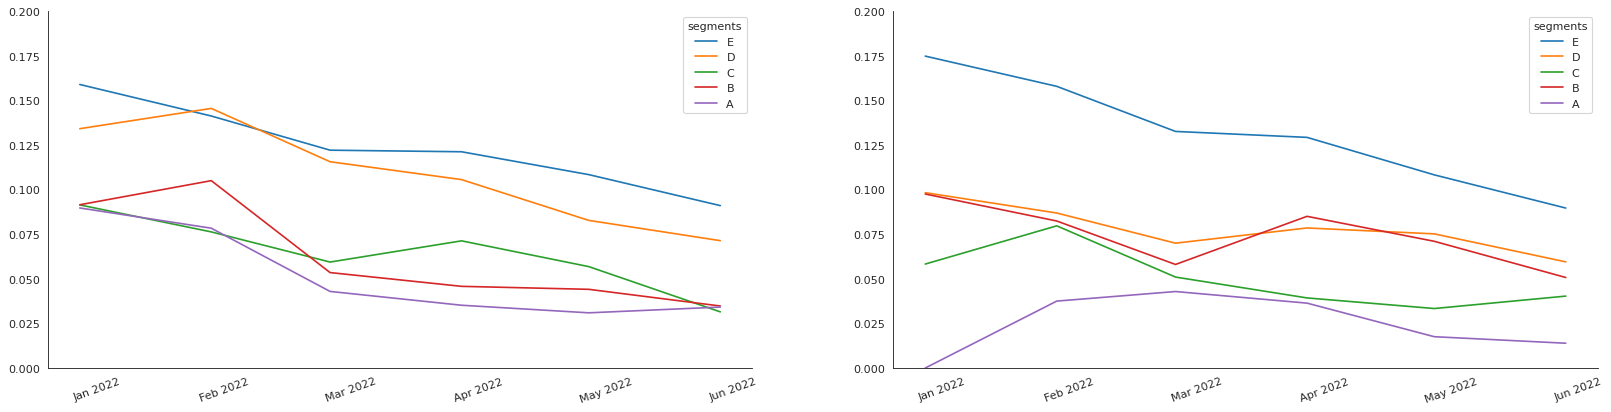

In [205]:
get_lineplot(
  data_list=[
    report_ativacao,
    report_old_risk
  ],
  specs={
    0: {"x_grid_loc": 0, "y_grid_loc": 0, "y_axis": "prob_default", "hue": "segments", "title": ""},
    1: {"x_grid_loc": 0, "y_grid_loc": 1, "y_axis": "prob_default", "hue": "segments", "title": ""}
  }
)